In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypesto import store

from inference.nlme_objective import ObjectiveFunctionNLME
from inference.ploting_routines import visualize_pesto_result
from inference.helper_functions import compute_error_estimate

In [ ]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde', 
              'pharmacokinetic_model', 
              'clairon_small_model'][0]

In [ ]:
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    individual_model = FroehlichModelSimple(load_best=True)
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    individual_model = FroehlichModelDetailed(load_best=True)
elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    individual_model = FroehlichModelSDE(load_best=True)    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    individual_model = PharmacokineticModel(load_best=True)    
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel
    individual_model = ClaironSmallModel(load_best=True)
else:
    raise NotImplementedError('model not implemented')

# assemble simulator and prior
trainer = individual_model.build_trainer('../networks/' + individual_model.network_name)
individual_model.plot_example()

In [ ]:
obj_fun_amortized = ObjectiveFunctionNLME(model_name=individual_model.name,
                                          param_samples=np.empty((1,1,1)),
                                          prior_mean=individual_model.prior_mean,
                                          prior_std=individual_model.prior_std,
                                          covariance_format='diag',
                                          covariates=None,
                                          covariate_mapping=None,
                                          prior_type=individual_model.prior_type,
                                          prior_bounds=individual_model.prior_bounds if hasattr(individual_model, 'prior_bounds') else None,  # for uniform prior
                                          )

In [ ]:
# load results
filename = '../output/test_results.hdf5'
result_optimization = store.read_result(filename)

In [ ]:
visualize_pesto_result(result_optimization)

In [ ]:
test_n_cells = [50, 100, 200, 500, 1000, 5000, 10000]
n_samples_opt_list = [10, 50, 100, 1000]
n_runs = 20 #100
time_opt = np.zeros((len(test_n_cells), len(n_samples_opt_list), n_runs))
rel_error = np.zeros((len(test_n_cells), len(n_samples_opt_list), n_runs))

    
for nc, n_cells in enumerate(test_n_cells):
    for ns, n_samples in enumerate(n_samples_opt_list):
        # load results
        #filename = f'output/scalability/{individual_model.name}_cells_{n_cells}_samples_{n_samples}.hd5'
        filename =  '../output/test_results.hdf5'
        result_optimization = store.read_result(filename)
        results_params = np.array(result_optimization.optimize_result.x)
        assert results_params.shape[0] == n_runs
                
        # load true population parameters
        true_pop_parameters = individual_model.load_synthetic_parameter(n_data=n_cells)
        
        for i_r, res in enumerate(results_params):
            # transform results
            estimated_beta = res[:individual_model.n_params]
            estimated_var = np.exp(-res[individual_model.n_params:individual_model.n_params*2])
            estimated_params = np.concatenate((estimated_beta, estimated_var))
             
            # compute relative error of parameter estimated as minimum over multi_starts
            rel_error[nc, ns, i_r] = compute_error_estimate(estimated_params,
                                                            true_pop_parameters,
                                                            bi_modal=True if 'Simple' in individual_model.name else False)
             
        # get duration of optimization procedure (in seconds)
        time_opt[nc, ns, :] = np.array(result_optimization.optimize_result.time) / 60 / 60
        break
    break

In [84]:
# read results from monolix
compute_relative_error = False  # relative to true parameter values
epsilon = 1e-4

if 'simple' in model_name:
    reorder_monolix_params = [0,1,2,3,4,10,5,6,7,8,9]
elif 'detailed' in model_name:
    reorder_monolix_params = [0,1,2,3,4,5,6,7,8,9,20,10,11,12,13,14,15,16,17,18,19]
else:
    raise NotImplementedError('model not implemented')

monolix_errors = np.ones(len(test_n_cells)) * np.nan
timing_monolix = np.zeros(len(test_n_cells)) * np.nan

for cell_idx, n_cells in enumerate(test_n_cells):
    if n_cells == 1000: continue
    if 'detailed' in model_name and n_cells == 200: continue 
    
    estimates_monolix = pd.read_csv(f'results_monolix/{model_name}/estimates/synthetic_{n_cells}_poppars.csv',
                                    index_col=0, header=0)
    true_sample_parameters = pd.read_csv(f'../data/synthetic/sample_pop_parameters.csv',
                                      index_col=0, header=0).loc[f'{n_cells}'].values

    results_to_compare = []
    for col in estimates_monolix.columns:
        temp_res = estimates_monolix[col].values[reorder_monolix_params]
        temp_res[5] = np.log(temp_res[5]) # standard deviation is not on log-scale
        temp_res = np.concatenate((temp_res, [0]))  # add variance of noise
        results_to_compare.append(temp_res)
    error_mono = compute_error_estimate(np.array(results_to_compare), 
                                        true_sample_parameters, 
                                        bi_modal=True if 'Simple' in individual_model.name else False,
                                        relative_error=compute_relative_error)
    # take min over multi-starts
    error_mono.sort()
    monolix_errors[cell_idx] = np.min(error_mono)

    # get timing    
    if 'detailed' in model_name:
        # likelihood were not always available, results are sorted
        best_runs = pd.read_csv(f'results_monolix/{model_name}/estimates/synthetic_{n_cells}_complete_likelihoods.csv', 
                                index_col=0, header=0)['run'][:10]
    else:
        # results are sorted
        best_runs = pd.read_csv(f'results_monolix/{model_name}/estimates/synthetic_{n_cells}_likelihoods.csv', 
                                index_col=0, header=0)['run'][:10]
        
    timing_monolix_df = pd.read_csv(f'results_monolix/{model_name}/optimization_times/synthetic_{n_cells}_timings.csv', 
                                 header=0)
    
    timing_monolix[cell_idx] = 0
    for run in timing_monolix_df.values:
        if run[-1] in best_runs.values:
            timing_monolix[cell_idx] += run[0]
    # average over number of runs
    timing_monolix[cell_idx] = timing_monolix[cell_idx] / best_runs.size / 60 / 60  # in hours

ValueError: Incorrect use of keyword argument 'rotation'. Keyword arguments other than 'minor' modify the text labels and can only be used if 'labels' are passed as well.

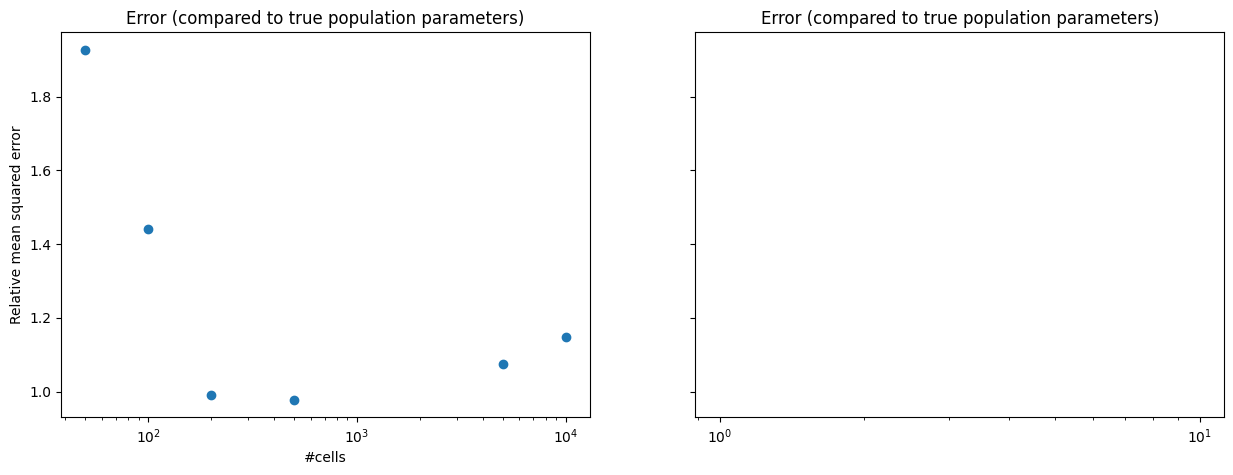

In [87]:
figure, axis = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(15, 5))

#for j, n_samples_opt in enumerate(n_samples_opt_list):
#    axis[0].plot(test_n_cells, rel_error[:, j], label=f'#posterior samples: {n_samples_opt}')
#    axis[1].scatter(np.array(test_n_cells) * n_samples_opt, rel_error[:, j],
#                    label=f'#posterior samples: {n_samples_opt}')

axis[0].scatter(test_n_cells, monolix_errors, label=f'baseline')

axis[0].set_ylabel('$t\,[s]$')
axis[0].set_ylabel('Relative mean squared error')
axis[0].set_xscale('log')
axis[1].set_xscale('log')
#axis[0].set_yscale('log')
axis[0].set_title('Error (compared to true population parameters)')
axis[1].set_title('Error (compared to true population parameters)')
axis[0].set_xlabel('#cells')
axis[0].set_xticks(ticks=test_n_cells, rotation=60)
axis[1].set_xlabel('#cells $\cdot$ #posterior samples')
axis[0].legend()
axis[1].legend()
#axis[1].set_ylim(0, 8)
plt.tight_layout()

plt.show()

ValueError: Incorrect use of keyword argument 'rotation'. Keyword arguments other than 'minor' modify the text labels and can only be used if 'labels' are passed as well.

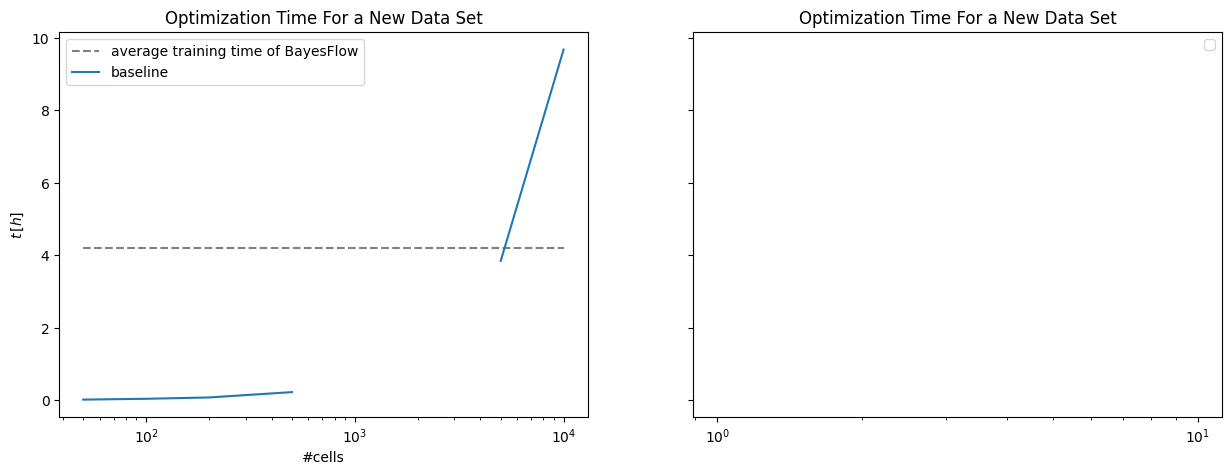

In [86]:
figure, axis = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(15, 5))

axis[0].hlines(4.2, xmin=test_n_cells[0], xmax=test_n_cells[-1], color='grey', linestyle='--',
               label=f'average training time of BayesFlow')

#for j, n_samples_opt in enumerate(n_samples_opt_list):
#    axis[0].plot(test_n_cells, time_opt[:, j] / 60 / 60, label=f'#posterior samples: {n_samples_opt}')
#axis[1].scatter(np.array(test_n_cells) * n_samples_opt, time_opt[:, j] / 60 / 60,
#                    label=f'#posterior samples: {n_samples_opt}')

axis[0].scatter(test_n_cells, timing_monolix, label=f'baseline')

# joint settings
axis[0].set_ylabel('$t\,[h]$')
#axis[0].set_yscale('log')
#axis[1].set_yscale('log')
axis[0].set_xscale('log')
axis[1].set_xscale('log')
axis[0].set_title('Optimization Time For a New Data Set')
axis[1].set_title('Optimization Time For a New Data Set')
axis[0].legend()
axis[1].legend()

# other settings
axis[0].set_xlabel('#cells')
axis[0].set_xticks(ticks=test_n_cells, rotation=60)
axis[1].set_xlabel('#cells $\cdot$ #posterior samples')
plt.tight_layout()
plt.show()